In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.io
import collections
import pandas as pd

from keras.models import Sequential
from keras.models import model_from_json
from keras.layers import Dense, Conv2D, Flatten
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model

from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

Using TensorFlow backend.


## Create dataset

In [2]:
def load_matlab_dictionary(file_path, file_name, key):

    # Read mat file dictionary
    dictionary = scipy.io.loadmat(file_path + file_name)

    # Access item of a dictionary
    array = dictionary[key]

    return array

def load_hologram_dataset(path, file_path, file_name, key):

    # Load dictionary
    dat = load_matlab_dictionary(file_path, file_name, key)

    # Number of holograms
    nb_holograms = dat.shape[2]

    # Number of class
    nb_class = 5

    # Number of holograms per class
    nb_holograms_class = int(nb_holograms/nb_class)

    # Save npy file
#     np.save('dat.npy', dat)

    return dat, nb_holograms, nb_class, nb_holograms_class

def load_dataset():

    # Current directory
    cwd = os.getcwd()

    # Directory path
    path = str((Path(cwd).parent).parent)
    file_path = path + '\\output\\dataset\\'

    # File names
    file_name = 'hDataset.mat'
    key = 'hDataset'

    print('----- Loading hologram dataset... -----')

    # Load hologram (matfile dictionary)
    dat, nb_holograms, nb_class, nb_holograms_class = load_hologram_dataset(path, file_path, file_name, key)

    # Display results
    print('Hologram dataset loaded (matlab file dictionary)')
    print('Hologram dataset shape: ', dat.shape)
    print('Total number of holograms: ' + str(nb_holograms))
    print('Number of holograms per class: ' + str(nb_holograms_class))
    print('Hologram dataset saved in .npy file!\n')

    return dat, nb_holograms, nb_class, nb_holograms_class

def reshape_dataset(dat, nb_holograms):

    # Dimensions
    rows = dat.shape[0]
    columns = dat.shape[1]

    # Reshape the dataset so that the first dimension is the number of holograms
    dat_r = np.ones([nb_holograms, rows, columns], dtype=complex)
    for i in range(nb_holograms):
        dat_r[i, :, :] = dat[:, :, i]

    # Reshape the dataset to 1 dimension
    data_1D = np.reshape(dat_r, (1500, int(rows*columns)))

    return data_1D

def normalize(arr):

    max_value = np.max(np.max(arr, axis=0))
    min_value = np.min(np.min(arr, axis=0))
    arr = (arr - min_value) / (max_value - min_value)

    return arr

def normalize_dataset(nb_holograms, data_1D):

    # Normalize the examples
    data_1D_norm = np.zeros([nb_holograms, data_1D.shape[1]], dtype=complex)

    # Normalize each example
    for i in range(nb_holograms):
        data_1D_norm[i, :] = normalize(data_1D[i, :])

    return data_1D_norm

def compute_targets_array(nb_holograms, nb_class, nb_holograms_class):

    # Compute array of targets
    Y_array = np.ones([nb_holograms,])

    pos = 0
    for c in range(nb_class):
        for h in range(nb_holograms_class):
            Y_array[pos] = c
            pos = pos + 1

    # Save matrix
#     np.save('Y_array.npy', Y_array)

    return Y_array

def pre_processing(dat, nb_holograms, nb_class, nb_holograms_class):

    print('----- Data pre-procesing... -----')

    # Reshape the dataset to 1 dimension
    print('Reshaping dataset to 1 dimension...')
    data_1D = reshape_dataset(dat, nb_holograms)
    print('Dataset 1D shape: ', data_1D.shape)

    # Normalize the data
    print('Normalizing dataset...')
    data_1D_norm = normalize_dataset(nb_holograms, data_1D)
    print('Normalized dataset shape: ', data_1D_norm.shape)

    # Compute array of targets
    print('Computing Y_array...')
    Y_array = compute_targets_array(nb_holograms, nb_class, nb_holograms_class)

    # Verify
    print('Y_array shape: ', Y_array.shape)
    print(collections.Counter(Y_array))
    print('Y_array saved in a .npy file!\n')

    return data_1D_norm, Y_array

In [3]:
dat, nb_holograms, nb_class, nb_holograms_class = load_dataset()

# Prepare dateset (reshape, normalize, target's array)
data_1D_norm, Y_array = pre_processing(dat, nb_holograms, nb_class, nb_holograms_class)

----- Loading hologram dataset... -----
Hologram dataset loaded (matlab file dictionary)
Hologram dataset shape:  (200, 200, 1500)
Total number of holograms: 1500
Number of holograms per class: 300
Hologram dataset saved in .npy file!

----- Data pre-procesing... -----
Reshaping dataset to 1 dimension...
Dataset 1D shape:  (1500, 40000)
Normalizing dataset...
Normalized dataset shape:  (1500, 40000)
Computing Y_array...
Y_array shape:  (1500,)
Counter({0.0: 300, 1.0: 300, 2.0: 300, 3.0: 300, 4.0: 300})
Y_array saved in a .npy file!



In [4]:
data_1D_norm.shape

(1500, 40000)

In [5]:
dataset = data_1D_norm

In [6]:
def load_points_dataset():
    
    # Current directory
    cwd = os.getcwd()

    # Directory path
    path = str((Path(cwd).parent).parent)
    file_path = path + '\\output\\dataset\\'

    # File names
    file_name = 'pDataset.mat'
    key = 'pDataset'

    points = load_matlab_dictionary(file_path, file_name, key)
    
    return points

In [7]:
points_dataset = load_points_dataset()
points_dataset.shape

(4500, 3)

In [8]:
def positions_points_dataset(class_nb, nb_holograms_class):
    
    # Initial position in the points dataset
    init = 0
    for nb in range(1, class_nb):
        init = nb * nb_holograms_class + init
    
    # Final position in the points dataset
    fin = 0
    for nb in range(1, class_nb + 1):
        fin = nb * nb_holograms_class + fin
    fin = fin - 1

    return init, fin

In [9]:
def load_points_dataset_one_class(data, class_nb, nb_holograms_class):
    
    # Initial and final position in the points dataset
    init, fin = positions_points_dataset(class_nb, nb_holograms_class)

    points_one_class = data[init:(fin + 1), :]
    
    return points_one_class

In [10]:
class_nb = 1

p_dataset  = load_points_dataset_one_class(points_dataset, class_nb, nb_holograms_class)
p_dataset.shape

(300, 3)

In [11]:
X_data = dataset[0:300,:]
X_data.shape

(300, 40000)

In [12]:
Y_data = p_dataset[:,0]
Y_data.shape

(300,)

In [13]:
y = pd.DataFrame(Y_data)
y

,0
0,0.000786
1,0.000523
2,-0.000766
3,-0.000760
4,-0.000875
...,...
295,0.000811
296,-0.000422
297,0.000612
298,-0.000538


In [14]:
# Create the model
model = Sequential()  # build a model layer by layer

In [15]:
X_data.shape[1]

40000

In [16]:

# Add model layers

# First layer (hidden layer)
nb_nodes1 = 1000
input_dim1 = X_data.shape[1] # 40000 
activation1 = 'relu' # Rectified linear unit (ReLU)

model.add(Dense(nb_nodes1, input_dim=input_dim1, activation=activation1))

# Second layer (hidden layer)
nb_nodes2 = 400
activation2 = 'relu' # Rectified linear unit (ReLU)

model.add(Dense(nb_nodes2, activation=activation2))

# Third layer (output layer)
activation3 = 'softmax'
model.add(Dense(1, activation='linear'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1000)              40001000  
_________________________________________________________________
dense_2 (Dense)              (None, 400)               400400    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 401       
Total params: 40,401,801
Trainable params: 40,401,801
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.compile(loss='mse', optimizer='adam', metrics=['mse'])


In [19]:
X_train = X_data
Y_train = np.reshape(Y_data, (-1,1))
Y_train.shape

(300, 1)

In [20]:
%%time
# Train the model
nb_epochs = 50
nb_batchs = 1000

history = model.fit(X_train, Y_train, epochs=nb_epochs, verbose=1)


Epoch 1/50


c:\users\flucasamar\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


300/300 [==============================] - 3s 11ms/step - loss: 5592.0955 - mse: 5592.0957
Epoch 2/50
300/300 [==============================] - 3s 11ms/step - loss: 50.1365 - mse: 50.1365
Epoch 3/50
300/300 [==============================] - 3s 11ms/step - loss: 13.6090 - mse: 13.6090
Epoch 4/50
300/300 [==============================] - 3s 11ms/step - loss: 4.4229 - mse: 4.4229
Epoch 5/50
300/300 [==============================] - 3s 11ms/step - loss: 1.6201 - mse: 1.6201
Epoch 6/50
300/300 [==============================] - 3s 11ms/step - loss: 0.6099 - mse: 0.6099
Epoch 7/50
300/300 [==============================] - 3s 11ms/step - loss: 0.3038 - mse: 0.3038
Epoch 8/50
300/300 [==============================] - 3s 11ms/step - loss: 0.2691 - mse: 0.2691
Epoch 9/50
300/300 [==============================] - 3s 11ms/step - loss: 0.1345 - mse: 0.1345
Epoch 10/50
300/300 [==============================] - 3s 11ms/step - loss: 0.0753 - mse: 0.0753
Epoch 11/50
300/300 [===================

dict_keys(['loss', 'mse'])


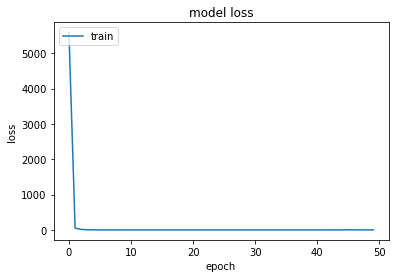

In [21]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [30]:
predictions = model.predict(X_train)
df = pd.DataFrame(predictions)
df

,0
0,-0.226264
1,-0.008546
2,-0.667060
3,-0.460076
4,-0.357089
...,...
295,-0.445419
296,-0.613450
297,-0.475568
298,-0.299968


In [ ]:
┬

In [101]:
# Compile the model
loss_fct = 'categorical_crossentropy' # Used for classification problem
opt_fct = 'adam' # Popular version of Gradient Descent
metrics_fct = ['accuracy'] # Classification problem

model.compile(loss=loss_fct, optimizer=opt_fct, metrics=metrics_fct)

# Train the model
nb_epochs = 50
nb_batchs = 1000

history = model.fit(X_data, Y_data, epochs=nb_epochs, verbose=1)

ValueError: You are passing a target array of shape (300, 1) while using as loss `categorical_crossentropy`. `categorical_crossentropy` expects targets to be binary matrices (1s and 0s) of shape (samples, classes). If your targets are integer classes, you can convert them to the expected format via:
```
from keras.utils import to_categorical
y_binary = to_categorical(y_int)
```

Alternatively, you can use the loss function `sparse_categorical_crossentropy` instead, which does expect integer targets.

## Example

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor

In [32]:
#Variables
# d = np.loadtxt("cars.csv", delimiter=",")
dataframe = pd.read_csv("cars.csv", delimiter=",")
dataframe

,age,gender,miles,debt,income,sales
0,28,0,23,0,4099,620
1,26,0,27,0,2677,1792
2,30,1,58,41576,6215,27754
3,26,1,25,43172,7626,28256
4,20,1,17,6979,8071,4438
...,...,...,...,...,...,...
958,22,0,11,8778,9829,1593
959,19,1,23,4850,3470,4742
960,28,1,28,9312,2720,12771
961,50,0,29,51343,8713,28511


In [42]:
dataset = dataframe.values
x = dataset[:,0:5]
y = dataset[:,5]
print(y.shape)
print(type(y))
y = np.reshape(y, (-1,1))
print(y.shape)
print(type(y))
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
print(scaler_x.fit(x))
xscale=scaler_x.transform(x)
print(scaler_y.fit(y))
yscale=scaler_y.transform(y)

(963,)
<class 'numpy.ndarray'>
(963, 1)
<class 'numpy.ndarray'>
MinMaxScaler()
MinMaxScaler()


In [49]:
X_train, X_test, y_train, y_test = train_test_split(xscale, yscale)

In [50]:
X_train.shape

(722, 5)

In [51]:
model = Sequential()
model.add(Dense(12, input_dim=5, kernel_initializer='normal', activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12)                72        
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 185
Trainable params: 185
Non-trainable params: 0
_________________________________________________________________


In [52]:
model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])

In [53]:
>>> history = model.fit(X_train, y_train, epochs=150, batch_size=50,  verbose=1, validation_split=0.2)

Train on 577 samples, validate on 145 samples
Epoch 1/150
577/577 [==============================] - 0s 260us/sample - loss: 0.2518 - mean_squared_error: 0.2518 - mean_absolute_error: 0.3954 - val_loss: 0.2213 - val_mean_squared_error: 0.2213 - val_mean_absolute_error: 0.3762
Epoch 2/150
577/577 [==============================] - 0s 38us/sample - loss: 0.1607 - mean_squared_error: 0.1607 - mean_absolute_error: 0.2929 - val_loss: 0.1343 - val_mean_squared_error: 0.1343 - val_mean_absolute_error: 0.2788
Epoch 3/150
577/577 [==============================] - 0s 36us/sample - loss: 0.0934 - mean_squared_error: 0.0934 - mean_absolute_error: 0.2359 - val_loss: 0.0791 - val_mean_squared_error: 0.0791 - val_mean_absolute_error: 0.2357
Epoch 4/150
577/577 [==============================] - 0s 36us/sample - loss: 0.0645 - mean_squared_error: 0.0645 - mean_absolute_error: 0.2179 - val_loss: 0.0619 - val_mean_squared_error: 0.0619 - val_mean_absolute_error: 0.2212
Epoch 5/150
577/577 [============

577/577 [==============================] - 0s 26us/sample - loss: 0.0112 - mean_squared_error: 0.0112 - mean_absolute_error: 0.0789 - val_loss: 0.0180 - val_mean_squared_error: 0.0180 - val_mean_absolute_error: 0.0953
Epoch 72/150
577/577 [==============================] - 0s 24us/sample - loss: 0.0112 - mean_squared_error: 0.0112 - mean_absolute_error: 0.0792 - val_loss: 0.0180 - val_mean_squared_error: 0.0180 - val_mean_absolute_error: 0.0945
Epoch 73/150
577/577 [==============================] - 0s 24us/sample - loss: 0.0112 - mean_squared_error: 0.0112 - mean_absolute_error: 0.0788 - val_loss: 0.0180 - val_mean_squared_error: 0.0180 - val_mean_absolute_error: 0.0957
Epoch 74/150
577/577 [==============================] - 0s 24us/sample - loss: 0.0112 - mean_squared_error: 0.0112 - mean_absolute_error: 0.0792 - val_loss: 0.0180 - val_mean_squared_error: 0.0180 - val_mean_absolute_error: 0.0943
Epoch 75/150
577/577 [==============================] - 0s 24us/sample - loss: 0.0112 - m

577/577 [==============================] - 0s 24us/sample - loss: 0.0104 - mean_squared_error: 0.0104 - mean_absolute_error: 0.0756 - val_loss: 0.0170 - val_mean_squared_error: 0.0170 - val_mean_absolute_error: 0.0888
Epoch 142/150
577/577 [==============================] - 0s 28us/sample - loss: 0.0103 - mean_squared_error: 0.0103 - mean_absolute_error: 0.0751 - val_loss: 0.0168 - val_mean_squared_error: 0.0168 - val_mean_absolute_error: 0.0918
Epoch 143/150
577/577 [==============================] - 0s 24us/sample - loss: 0.0104 - mean_squared_error: 0.0104 - mean_absolute_error: 0.0756 - val_loss: 0.0168 - val_mean_squared_error: 0.0168 - val_mean_absolute_error: 0.0891
Epoch 144/150
577/577 [==============================] - 0s 24us/sample - loss: 0.0102 - mean_squared_error: 0.0102 - mean_absolute_error: 0.0749 - val_loss: 0.0167 - val_mean_squared_error: 0.0167 - val_mean_absolute_error: 0.0899
Epoch 145/150
577/577 [==============================] - 0s 24us/sample - loss: 0.0103

dict_keys(['loss', 'mean_squared_error', 'mean_absolute_error', 'val_loss', 'val_mean_squared_error', 'val_mean_absolute_error'])


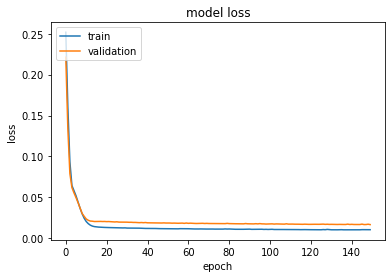

In [54]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [55]:
Xnew = np.array([[40, 0, 26, 9000, 8000]])

In [73]:
Xnew = np.array([[40, 0, 26, 9000, 8000]])
Xnew= scaler_x.transform(Xnew)
ynew= model.predict(Xnew)
#invert normalize
ynew = scaler_y.inverse_transform(y_test) 
Xnew = scaler_x.inverse_transform(X_test)
pos = 20
print("X = %s, Predicted = %s" % (Xnew[pos, 4], ynew[pos]))

X = 4221.0, Predicted = [14767.]
